In [122]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [217]:
import html
import urllib

from helper_functions import *

Reading data
------------

In [124]:
#link_network_pos = pd.read_pickle('link_network_w_position.df')
#finished_paths = pd.read_pickle('finished_paths_w_positions.df')
#unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

In [125]:
data_path = ''

def read_tsv(file_name, names=None):
    
    file_path = data_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [126]:
graphs_path = ''
!ls 

P3.ipynb                              link_network_w_position.df
P3_FIA.ipynb                          links.tsv
README.md                             paths_finished.tsv
__pycache__                           paths_unfinished.tsv
articles.tsv                          plaintext_articles
categories.tsv                        preliminary_analysis.ipynb
degree_centrality_plot.html           tong_new_analysis.ipynb
finished_paths_w_positions.df         tong_notes.docx
helper_functions.py                   unfinished_paths_w_positions.df
interactive_plots.html                wikispeedia_articles_plaintext.tar.gz


In [127]:
!head 'categories.tsv'

# Hierarchical categories of all articles.
# Many articles have more than one category. Some articles have no category.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article   category
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:


In [128]:
link_network = read_tsv('links', names=['source', 'target'])
display(link_network.head(5))
link_network.shape

# link_network = link_network.applymap(urllib.parse.unquote_plus).copy()

,source,target
0,linkSource,linkTarget
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain


(119883, 2)

In [208]:
categories = read_tsv('categories')
display(categories.head(5))
categories.shape


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
1,%C3%85land,subject.Countries
2,%C3%85land,subject.Geography.European_Geography.European_...
3,%C3%89douard_Manet,subject.People.Artists
4,%C3%89ire,subject.Countries


(5203, 2)

In [209]:
finished_paths = read_tsv('paths_finished')
display(finished_paths.head(5))
finished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,rating
0,"# Articles in a path are separated by "";"".",NaN,NaN,NaN,NaN
1,"# Back clicks are represented as ""<"".",NaN,NaN,NaN,NaN
2,# Ratings are optionally given by the user aft...,NaN,NaN,NaN,NaN
3,"# Missing ratings are represented as ""NULL"".",NaN,NaN,NaN,NaN
4,hashedIpAddress,timestamp,durationInSec,path,rating


(51323, 5)

In [210]:
unfinished_paths = read_tsv('paths_unfinished')
display(unfinished_paths.head(5))
unfinished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
1,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
2,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
3,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
4,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout


(24874, 6)

In [211]:
# Convert 'durationInSec' to numeric, setting errors='coerce' to turn any non-numeric data into NaN
finished_paths['durationInSec'] = pd.to_numeric(finished_paths['durationInSec'], errors='coerce')
unfinished_paths['durationInSec'] = pd.to_numeric(unfinished_paths['durationInSec'], errors='coerce')

# Now, you can decide to fill NaN with a value or drop them
# For example, to fill NaN values with the mean:
finished_paths['durationInSec'].fillna(finished_paths['durationInSec'].mean(), inplace=True)
unfinished_paths['durationInSec'].fillna(unfinished_paths['durationInSec'].mean(), inplace=True)

# Or, to drop NaN values instead (choose one approach):
# finished_paths.dropna(subset=['durationInSec'], inplace=True)
# unfinished_paths.dropna(subset=['durationInSec'], inplace=True)

# Add the 'finished?' column to each DataFrame
finished_paths['finished?'] = 1
unfinished_paths['finished?'] = 0

# Concatenate the two DataFrames
all_paths = pd.concat([finished_paths, unfinished_paths])

# Now, create a summary DataFrame
summary = all_paths.groupby('finished?')['durationInSec'].agg(['count', 'mean']).reset_index()
summary.columns = ['Finished', 'Count', 'Average Time Played']

# Replace the 0 and 1 in the 'Finished' column with more descriptive labels
summary['Finished'] = summary['Finished'].map({1: 'Finished', 0: 'Unfinished'})

# Display the summary DataFrame
summary


,Finished,Count,Average Time Played
0,Unfinished,24874,835.257940
1,Finished,51323,158.276199


In [212]:
articles = read_tsv('articles')
display(articles.head(5))
articles.shape

,article
0,%C3%85land
1,%C3%89douard_Manet
2,%C3%89ire
3,%C3%93engus_I_of_the_Picts
4,%E2%82%AC2_commemorative_coins


(4603, 1)

Pre-processing
--------------

In [218]:
# count number of incoming and outgoing links for each article

source_counts = link_network['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = link_network['target'].value_counts().rename_axis('article').reset_index(name='target_count')

link_counts = pd.merge(source_counts, target_counts, how='outer')
link_counts.fillna(0, inplace=True)

In [219]:
# compute target to source link ratios

link_counts['target_source_ratio'] = link_counts['target_count'] / link_counts['source_count']
link_counts['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio
0,United_States,294.0,1551.0,5.275510
1,Driving_on_the_left_or_right,255.0,0.0,0.000000
2,List_of_countries,244.0,63.0,0.258197
3,List_of_circulating_currencies,236.0,8.0,0.033898
4,List_of_sovereign_states,216.0,43.0,0.199074


(4591, 4)

In [228]:
# remove links to and from non-Wikipedia articles (donation pages)
link_network = filter_rows_by_values(link_network, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
link_network_targets = link_network.groupby('source')['target'].apply(list).reset_index()

In [234]:
# Add the 'html_position' column to the DataFrame
link_network_targets['html_position'] = link_network_targets.apply(
    lambda row: find_html_position(row['source'], row['target']), axis=1
)


plaintext_articles/%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.html
Error reading HTML file for source: %C3%81ed%C3%A1n_mac_Gabr%C3%A1in
plaintext_articles/%C3%85land.html
Error reading HTML file for source: %C3%85land
plaintext_articles/%C3%89douard_Manet.html
Error reading HTML file for source: %C3%89douard_Manet
plaintext_articles/%C3%89ire.html
Error reading HTML file for source: %C3%89ire
plaintext_articles/%C3%93engus_I_of_the_Picts.html
Error reading HTML file for source: %C3%93engus_I_of_the_Picts
plaintext_articles/%E2%82%AC2_commemorative_coins.html
Error reading HTML file for source: %E2%82%AC2_commemorative_coins
plaintext_articles/10th_century.html
Error reading HTML file for source: 10th_century
plaintext_articles/11th_century.html
Error reading HTML file for source: 11th_century
plaintext_articles/12th_century.html
Error reading HTML file for source: 12th_century
plaintext_articles/13th_century.html
Error reading HTML file for source: 13th_century
plaintext_articles/14th_century.ht

In [190]:
display(link_network_targets.head(5))
link_network_targets.shape

,source,target,html_position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,...",-1
1,%C3%85land,"[20th_century, Baltic_Sea, Crimean_War, Curren...",-1
2,%C3%89douard_Manet,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1...",-1
3,%C3%89ire,"[Canada, English_language, George_VI_of_the_Un...",-1
4,%C3%93engus_I_of_the_Picts,"[D%C3%A1l_Riata, Durham, England, Great_Britai...",-1


(4586, 3)

In [191]:
# Convert back to rows of individual links with the relative position in the source article
m = pd.DataFrame([*link_network_targets['html_position']], link_network_targets.index).stack()\
      .rename_axis([None,'target']).reset_index(1, name='position')

link_network_pos = link_network_targets[['source']].join(m)

In [192]:
link_network_pos = pd.merge(link_network, link_network_pos, on=['source', 'target'], how='left')
link_network_pos.to_pickle('link_network_w_position.df')
display(link_network_pos.head(5))
link_network_pos.shape

ValueError: You are trying to merge on object and int64 columns for key 'target'. If you wish to proceed you should use pd.concat

In [ ]:
# calculate relative positions of links clicked in a path
def calculate_positions(arts):
    # ignore backclicks
    if '<' in arts: return [float('nan')]
    
    articles = arts.split(';')
    
    # ignore paths without actual steps
    if len(articles) < 2: return [float('nan')]
    
    positions = []
    
    art_idx = 0
    
    for idx, art in enumerate(articles[1:]):
        art0 = articles[art_idx]
        try:          
            positions.append(link_network_pos[(link_network_pos['source'] == art0)
                            & (link_network_pos['target'] == art)]['position'].values[0])
            art_idx = idx+1
        except:
            print(art0, art, arts)
            return [float('nan')]
    
    return positions

In [54]:
finished_paths['link_positions'] = finished_paths['path'].apply(calculate_positions)
unfinished_paths['link_positions'] = unfinished_paths['path'].apply(calculate_positions)

NameError: name 'calculate_positions' is not defined

In [55]:
# calculate average duration spent per article; backclicks are not considered
def get_avg_duration(row):
    num_steps = len(row['path'].split(';')) - 1
    return np.nan if num_steps <= 0 else row['durationInSec'] / num_steps

finished_paths['avg_duration'] = finished_paths.apply(get_avg_duration, axis=1)
unfinished_paths['avg_duration'] = unfinished_paths.apply(get_avg_duration, axis=1)

AttributeError: 'float' object has no attribute 'split'

In [234]:
# get average and maximum positions of link clicked in each path

finished_paths['avg_position'] = finished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)
unfinished_paths['avg_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)

finished_paths['max_position'] = finished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)
unfinished_paths['max_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)

# Preliminary analysis


## Categories

In [30]:
# parse and obtain categories in three levels

main_cat_set = set()
sec_cat_set = set()
thrd_cat_set = set()

for cat in categories['category']:
    levels = cat.split('.')
    if len(levels) > 1:
        main_cat_set.add(levels[1])
    if len(levels) > 2:
        sec_cat_set.add(levels[2])
    if len(levels) > 3:
        thrd_cat_set.add(levels[3])

print(f'There are {len(main_cat_set)} unique main categories, {len(sec_cat_set)} unique second level categories, and {len(thrd_cat_set)} unique third level categories.')


There are 15 unique main categories, 101 unique second level categories, and 27 unique third level categories.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 11.0 MB/s eta 0:00:0000:0100:01


/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


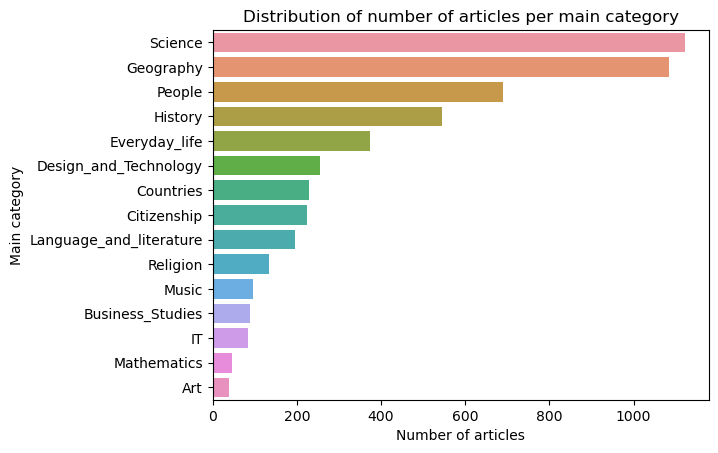

In [32]:
!pip install plotly

categories['main_category'] = categories['category'].str.split('.').str[1]
article_counts = categories['main_category'].value_counts()

sns.barplot(x=article_counts.values, y=article_counts.index, orient='horizontal')
plt.ylabel('Main category')
plt.xlabel('Number of articles')
plt.title('Distribution of number of articles per main category')
plt.show()

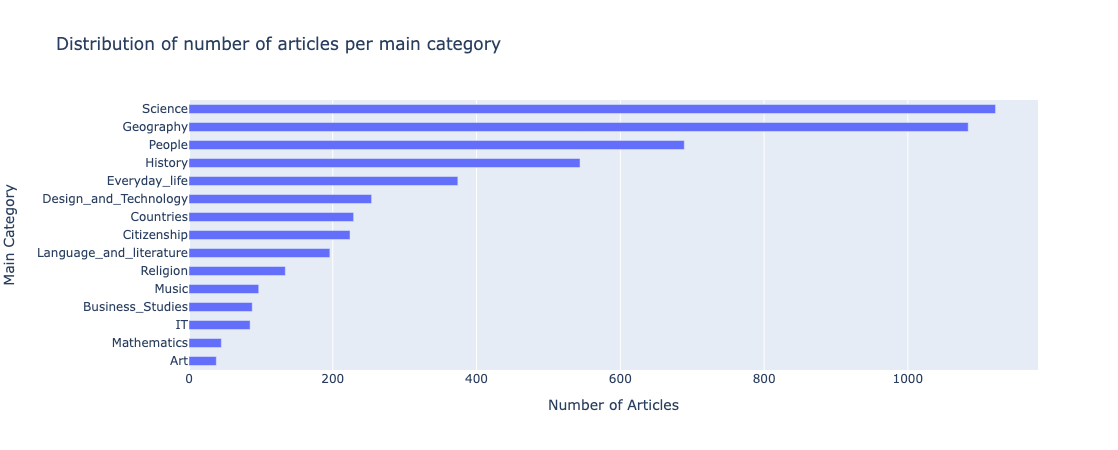

In [78]:
# Assuming 'categories' is your DataFrame and has a column 'category' from which you're extracting 'main_category'
categories['main_category'] = categories['category'].str.split('.').str[1]
article_counts = categories['main_category'].value_counts().reset_index()
article_counts.columns = ['main_category', 'count']  # Rename columns for clarity

# Now, create the Plotly figure
fig = px.bar(article_counts, y='main_category', x='count', orientation='h', 
             title='Distribution of number of articles per main category')

# Adjust the figure height to ensure all row names fit and bars are thicker
# The height might need to be adjusted based on the actual number of categories
fig_height = len(article_counts) * 30  # Example: 30 pixels per category

fig.update_layout(
    xaxis_title='Number of Articles', 
    yaxis_title='Main Category',
    height=fig_height,  # Set the figure height
    yaxis={'categoryorder':'total ascending'}  # This will order the y-axis based on the count
)

# To make bars thicker, adjust the width
# This can be achieved by customizing the individual bar trace
fig.update_traces(width=0.5)  # Adjust this value as needed to change bar thickness

# Show the interactive plot
fig.show()


## Link counts to and from each article

In [193]:
# descriptive statistics
link_counts.describe()

,source_count,target_count,target_source_ratio
count,4594.000000,4594.000000,4588.000000
mean,26.095559,26.095559,0.859222
std,24.197042,62.803231,1.439902
min,0.000000,0.000000,0.000000
25%,11.000000,2.000000,0.166667
50%,19.000000,8.000000,0.470588
75%,33.000000,25.000000,1.039486
max,294.000000,1551.000000,42.250000


/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498

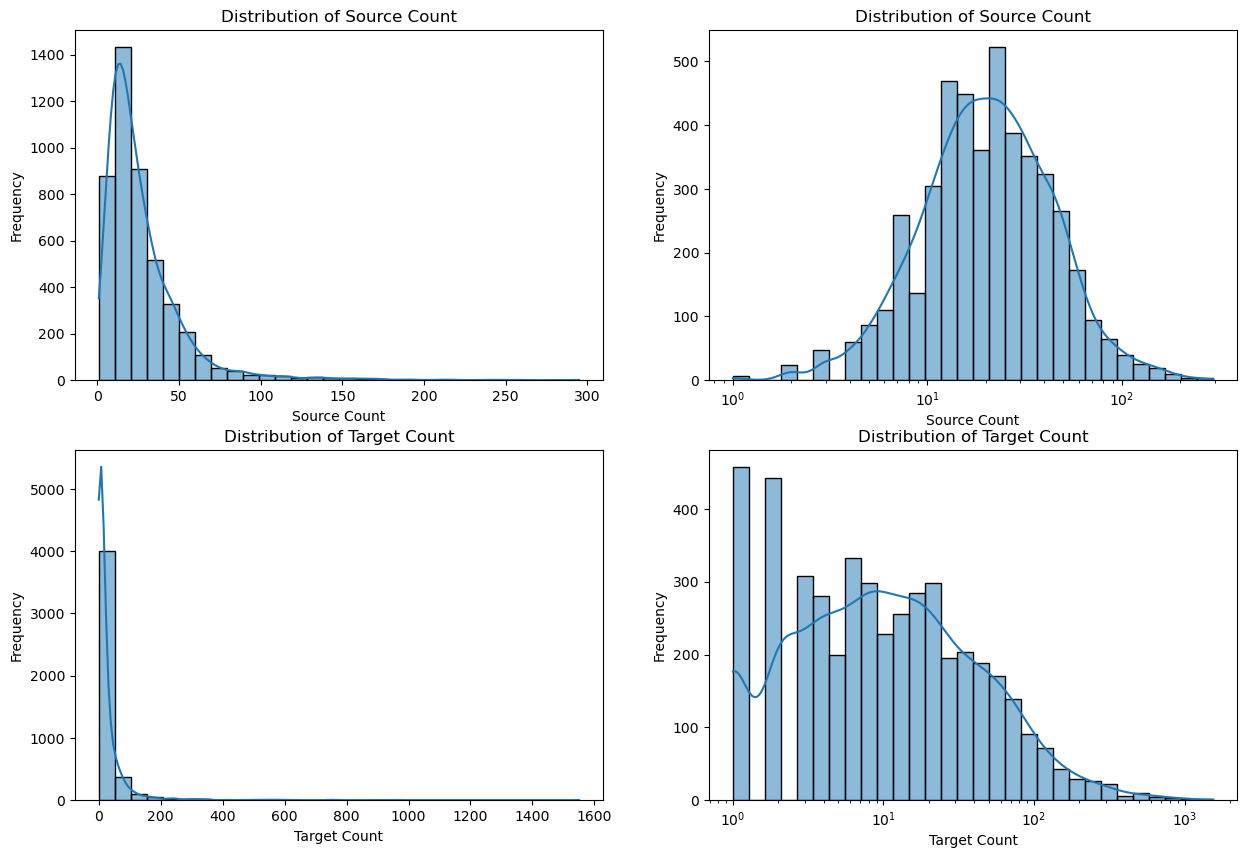

In [194]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

ax = axs[0, 0]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[0, 1]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[1, 0]

sns.histplot(link_counts['target_count'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')


ax = axs[1, 1]

sns.histplot(link_counts['target_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')

plt.show()


/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



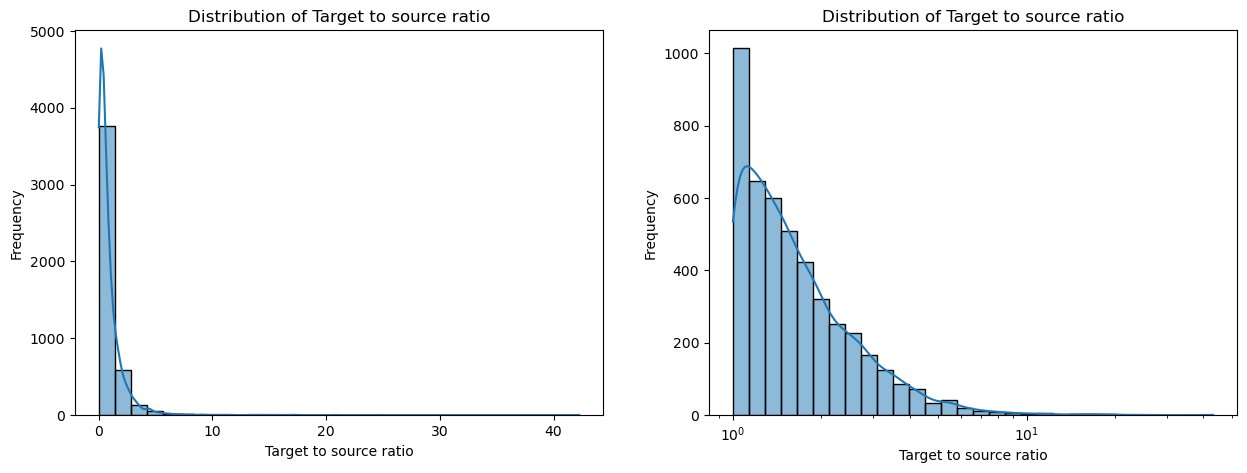

In [195]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax = axs[0]

sns.histplot(link_counts['target_source_ratio'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

ax = axs[1]

sns.histplot(link_counts['target_source_ratio']+1, bins=30, log_scale=True, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

plt.show()

In [196]:
source_25th_percentile = link_counts['source_count'].quantile(0.75)
target_25th_percentile = link_counts['target_count'].quantile(0.75)

hubs = link_counts[
    (link_counts['source_count'] >= source_25th_percentile) &
    (link_counts['target_count'] >= target_25th_percentile)
]

In [197]:
hubs_categories = pd.merge(hubs, categories, on='article')

In [198]:
sns.countplot(data=hubs_categories, y='main_category', order=hubs_categories['main_category'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Main category')
plt.title('Distribution of main categories for articles in the top 25% source and target counts')
plt.show()


KeyError: 'main_category'

## Identify hubs from finished paths

In [199]:
from collections import Counter
starting_articles = [str(i).split(';')[0] for i in finished_paths['path'].tolist() if pd.notnull(i)]
starting_categories = categories[categories['article'].isin(starting_articles)]

sns.countplot(data=starting_categories, y='main_category', order=starting_categories['main_category'].value_counts().index)
plt.xlabel('Main category')
plt.ylabel('Count')
plt.title('Distribution of main categories for starting articles (finished paths)')
plt.xticks(rotation=90)
plt.show()

KeyError: 'main_category'

In [200]:
from collections import Counter

all_paths = [i.split(';')[1:-1] for i in finished_paths['path'].tolist() if pd.notnull(i)]
all_articles = [article for path in all_paths for article in path]

article_counter = Counter(all_articles)
del article_counter['<']

# Most visited
top_hub_articles = [article for article, count in article_counter.most_common(100)]
top_hub_articles[:20]

['United_States',
 'Europe',
 'United_Kingdom',
 'Earth',
 'England',
 'Africa',
 'World_War_II',
 'North_America',
 'Germany',
 'Animal',
 'Mammal',
 'Human',
 'France',
 'Science',
 'English_language',
 'Periodic_table',
 'Computer',
 'Atlantic_Ocean',
 'India',
 'Agriculture']

In [201]:
top_hub_categories = categories[categories['article'].isin(top_hub_articles)]

sns.countplot(data=top_hub_categories, y='main_category', order=top_hub_categories['main_category'].value_counts().index)
plt.xlabel('Main category')
plt.ylabel('Count')
plt.title('Distribution of main categories for the top 100 visited articles')
plt.xticks(rotation=90)
plt.show()

KeyError: 'main_category'

In [202]:
# Assuming you've already installed Plotly and have the 'categories' DataFrame ready
import plotly.express as px

# Calculate the count of main categories
top_hub_categories_count = top_hub_categories['main_category'].value_counts().reset_index()
top_hub_categories_count.columns = ['main_category', 'count']  # Rename columns for clarity

# Create a pie chart
fig = px.pie(top_hub_categories_count, names='main_category', values='count', 
             title='Distribution of main categories for the top 100 visited articles')

# Customize the layout to increase the size of the pie chart
fig.update_layout(
    width=800,  # Width of the chart
    height=600,  # Height of the chart
    legend_title_text='Main Category'
)

# Customize the traces to show percentages on the chart and on hover
fig.update_traces(
    textinfo='percent',  # Show percent on the chart
    hoverinfo='label+percent'  # Show label and percent on hover
)

# Show the interactive plot
fig.show()


KeyError: 'main_category'

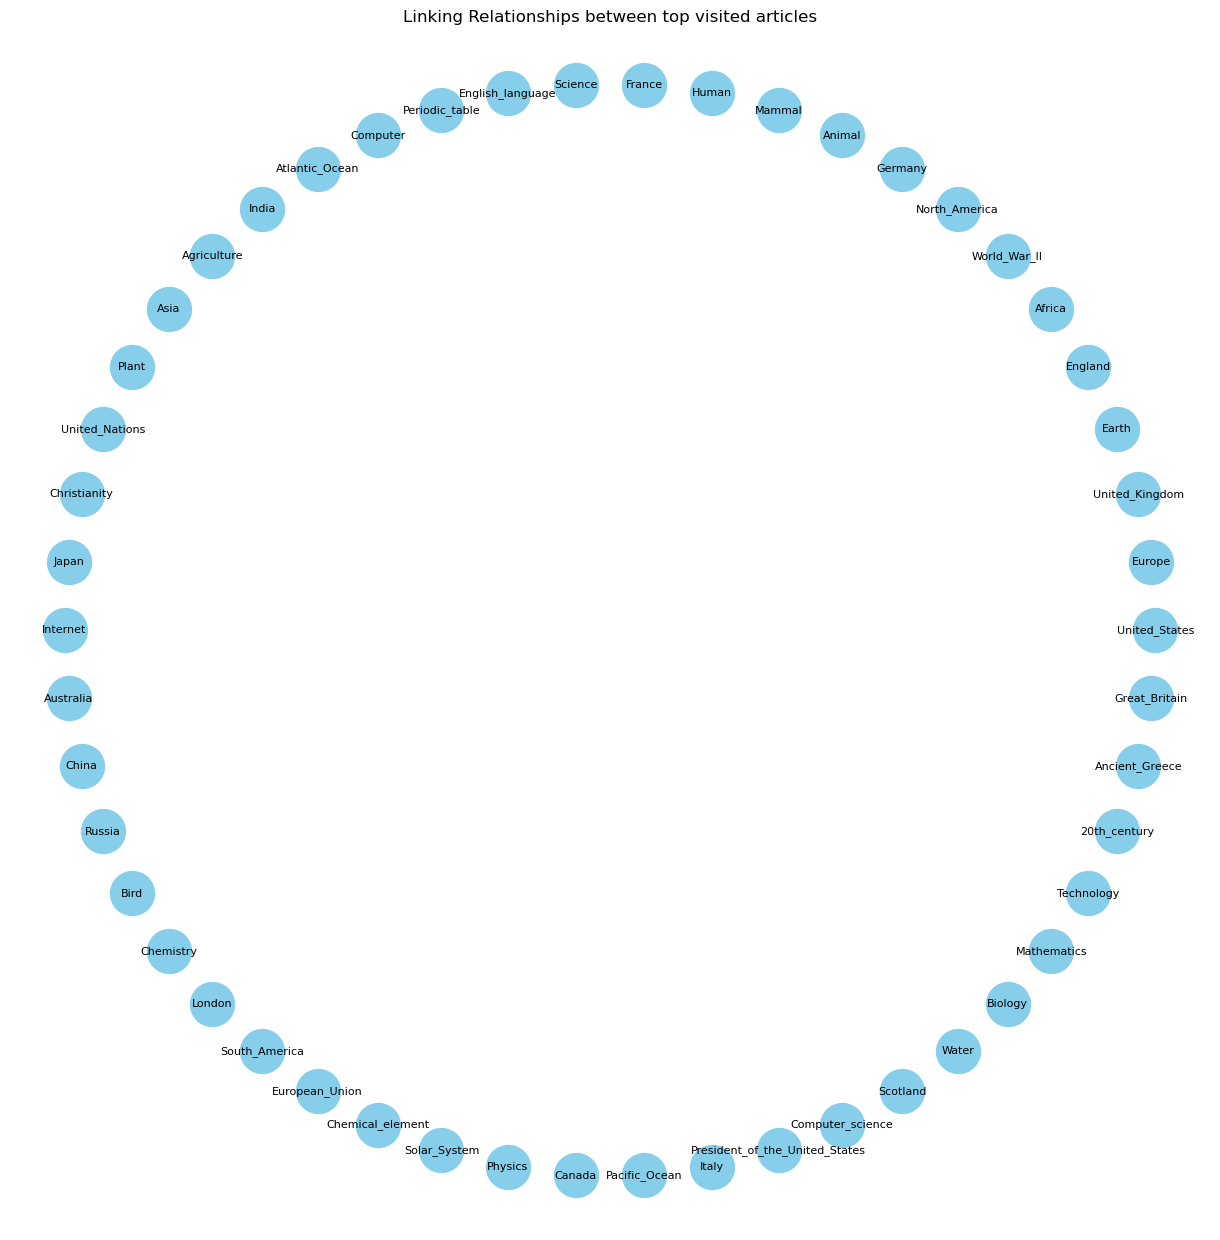

In [203]:
G = nx.DiGraph()

G.add_nodes_from(top_hub_articles[:50])

# Filter links that involve the top hub articles
filtered_links = link_network_pos[(link_network_pos['source'].isin(top_hub_articles[:50])
                                  ) & (link_network_pos['target'].isin(top_hub_articles[:50]))]

# Add edges between top hub articles
for _, row in filtered_links.iterrows():
    G.add_edge(row['source'], row['target'])


pos = nx.circular_layout(G, scale=1)

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=8)
plt.title('Linking Relationships between top visited articles')
plt.show()

## Position of links within the article

In [204]:
link_network_pos.describe()

,target,position
count,4586.0,4586.0
mean,0.0,-1.0
std,0.0,0.0
min,0.0,-1.0
25%,0.0,-1.0
50%,0.0,-1.0
75%,0.0,-1.0
max,0.0,-1.0


/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



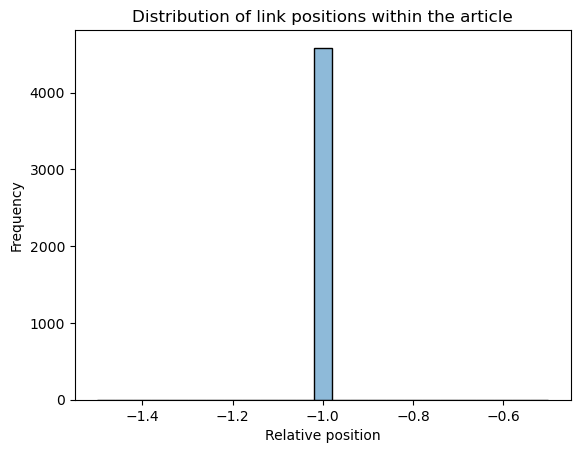

In [205]:
sns.histplot(data=link_network_pos, x='position', bins=25, kde=True)  # You can adjust the number of bins as needed
plt.title('Distribution of link positions within the article')
plt.xlabel('Relative position')
plt.ylabel('Frequency')
plt.show()

## Link positions vs. game duration (for finished and unfinished paths)

In [206]:
finished_paths.describe()

,durationInSec,finished?
count,51323.000000,51323.0
mean,158.276199,1.0
std,360.824327,0.0
min,0.000000,1.0
25%,60.000000,1.0
50%,107.000000,1.0
75%,183.000000,1.0
max,35091.000000,1.0


In [207]:
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

shortest_duration_positions = [position for positions in finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['link_positions'] for position in positions]
longest_duration_positions = [position for positions in finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['link_positions'] for position in positions]

sns.histplot(shortest_duration_positions, bins=20, kde=True, label='Shortest Duration (Bottom 25%)', color='blue', alpha=0.5)
sns.histplot(longest_duration_positions, bins=20, kde=True, label='Longest Duration (Top 25%)', color='orange', alpha=0.5)

plt.xlabel('Average Link Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Link Positions')

plt.legend()
plt.show()


KeyError: 'avg_duration'

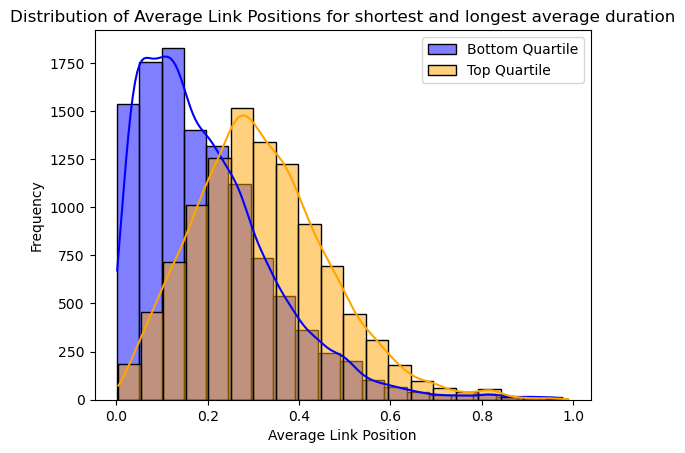

In [175]:
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

bottom_quartile_positions = finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['avg_position']
top_quartile_positions = finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['avg_position']

sns.histplot(bottom_quartile_positions, bins=20, kde=True, label='Bottom Quartile', color='blue', alpha=0.5)
sns.histplot(top_quartile_positions, bins=20, kde=True, label='Top Quartile', color='orange', alpha=0.5)

plt.xlabel('Average Link Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Link Positions for shortest and longest average duration')

plt.legend()
plt.show()


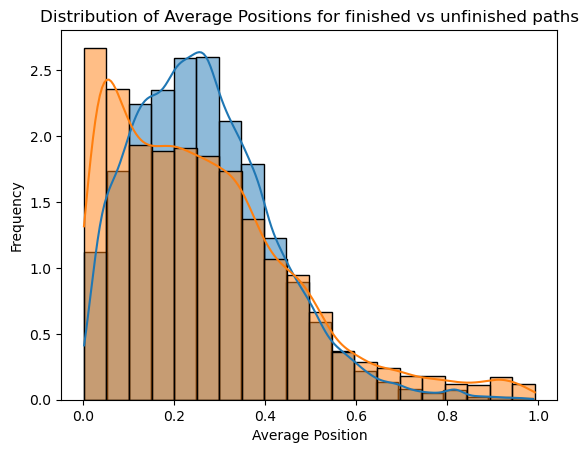

In [180]:
sns.histplot(data=finished_paths, x='avg_position', bins=20, kde=True, stat='density')
sns.histplot(data=unfinished_paths, x='avg_position', bins=20, kde=True, stat='density')

plt.xlabel('Average Position')
plt.ylabel('Frequency')
plt.title('Distribution of Average Positions for finished vs unfinished paths')

plt.show()

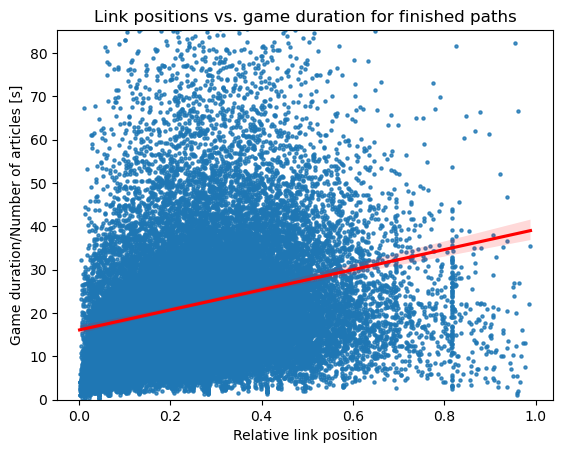

In [49]:
sns.regplot(y='avg_duration', x='avg_position', data=finished_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5})
plt.ylabel('Game duration/Number of articles [s]')
plt.xlabel('Relative link position')
plt.ylim(0, finished_paths.avg_duration.quantile(0.99))
plt.title('Link positions vs. game duration for finished paths');

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Calculate the quartile thresholds
bottom_25_threshold = finished_paths['avg_duration'].quantile(0.25)
top_25_threshold = finished_paths['avg_duration'].quantile(0.75)

# Separate the positions based on quartiles
bottom_quartile_positions = finished_paths[finished_paths['avg_duration'] <= bottom_25_threshold]['avg_position']
top_quartile_positions = finished_paths[finished_paths['avg_duration'] >= top_25_threshold]['avg_position']

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# First plot on the left
sns.histplot(bottom_quartile_positions, bins=20, kde=True, label='Bottom Quartile', color='blue', alpha=0.5, ax=axs[0])
sns.histplot(top_quartile_positions, bins=20, kde=True, label='Top Quartile', color='orange', alpha=0.5, ax=axs[0])

axs[0].set_xlabel('Average Link Position')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Average Link Positions for shortest and longest average duration')
axs[0].legend()

# Second plot on the right
sns.histplot(data=finished_paths, x='avg_position', bins=20, kde=True, stat='density', label='Finished Paths', ax=axs[1])
sns.histplot(data=unfinished_paths, x='avg_position', bins=20, kde=True, stat='density', label='Unfinished Paths', ax=axs[1])

axs[1].set_xlabel('Average Position')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Average Positions for finished vs unfinished paths')
axs[1].legend()

plt.tight_layout()
plt.show()

# For interactive plots, we need to use Plotly instead of seaborn/matplotlib
# Here's how you could convert the above plots to interactive ones using Plotly:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create the subplots
fig = make_subplots(rows=1, cols=2)

# Plot 1: Distribution of Average Link Positions
fig.add_trace(
    go.Histogram(x=bottom_quartile_positions, nbinsx=20, name='Bottom Quartile', marker_color='blue', opacity=0.5),
    row=1, col=1
)
fig.add_trace(
    go.Histogram(x=top_quartile_positions, nbinsx=20, name='Top Quartile', marker_color='orange', opacity=0.5),
    row=1, col=1
)

# Plot 2: Distribution of Average Positions for finished vs unfinished paths
fig.add_trace(
    go.Histogram(x=finished_paths['avg_position'], nbinsx=20, name='Finished Paths', marker_color='green', opacity=0.5),
    row=1, col=2
)
fig.add_trace(
    go.Histogram(x=unfinished_paths['avg_position'], nbinsx=20, name='Unfinished Paths', marker_color='red', opacity=0.5),
    row=1, col=2
)

# Update layout for aesthetics
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5) # To make sure histograms are semi-transparent

# Show the interactive plot
fig.show()


KeyError: 'avg_duration'

<Axes: xlabel='type', ylabel='count'>

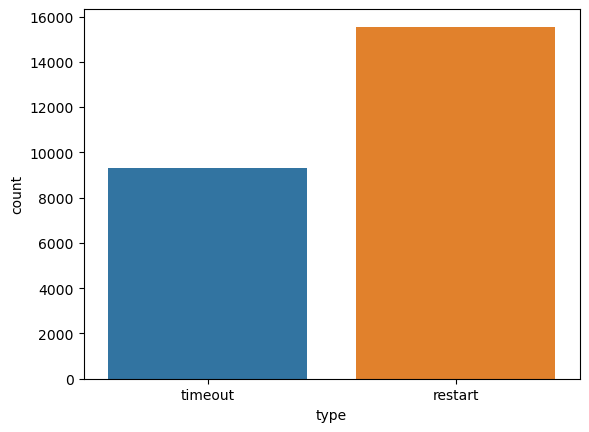

In [53]:
# Type of unfinished paths
sns.countplot(unfinished_paths, x="type")

In [75]:
# Compute the link positions for 'timeout' type
timeout_paths = unfinished_paths[unfinished_paths['type'] == 'timeout']

# Compute the link positions for 'restart' type
restart_paths = unfinished_paths[unfinished_paths['type'] == 'restart']


In [78]:
unfinished_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,2.487400e+04,24874.000000,24874.000000,14403.000000,14403.000000
mean,1.344765e+09,835.257940,311.256952,0.494428,0.265217
std,2.772208e+07,881.284271,507.813700,0.323777,0.202981
min,1.297056e+09,4.000000,2.000000,0.001334,0.001334
25%,1.320341e+09,86.000000,22.500000,0.178362,0.100774
50%,1.348587e+09,261.000000,46.000000,0.497656,0.230330
75%,1.367373e+09,1831.000000,379.000000,0.798926,0.373860
max,1.389823e+09,9089.000000,1962.000000,0.994416,0.992687


In [79]:
restart_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,1.555200e+04,15552.000000,15552.000000,8848.000000,8848.000000
mean,1.345831e+09,176.575296,38.041937,0.501969,0.264894
std,2.726300e+07,222.267962,64.544327,0.323732,0.200242
min,1.297095e+09,4.000000,2.000000,0.001334,0.001334
25%,1.324356e+09,48.000000,16.888889,0.185166,0.103084
50%,1.349253e+09,114.000000,26.600000,0.514357,0.233267
75%,1.367435e+09,224.000000,41.000000,0.806089,0.370505
max,1.389823e+09,5263.000000,1733.000000,0.994416,0.990781


In [80]:
timeout_paths.describe()

,timestamp,durationInSec,avg_duration,max_position,avg_position
count,9.322000e+03,9322.000000,9322.000000,5555.000000,5555.000000
mean,1.342987e+09,1934.145784,767.064709,0.482417,0.265733
std,2.838401e+07,241.892160,590.640342,0.323517,0.207286
min,1.297056e+09,1129.000000,30.323171,0.002269,0.002269
25%,1.313591e+09,1817.000000,315.166667,0.167470,0.096973
50%,1.346746e+09,1864.000000,545.125000,0.477419,0.224978
75%,1.367057e+09,1959.000000,922.000000,0.790840,0.378769
max,1.389799e+09,9089.000000,1962.000000,0.994191,0.992687


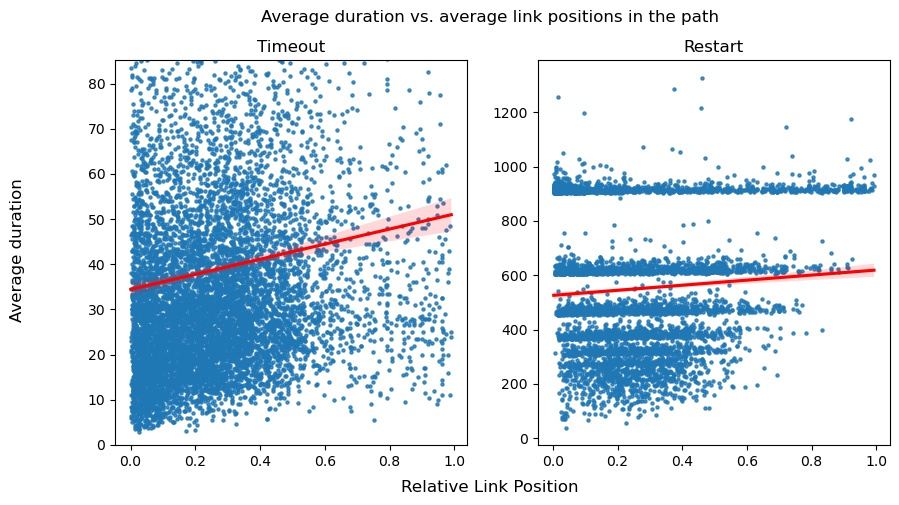

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


sns.regplot(y='avg_duration', x='avg_position', data=restart_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5}, ax=ax1)


ax1.set_ylim(0, finished_paths.avg_duration.quantile(0.99))

sns.regplot(y='avg_duration', x='avg_position', data=timeout_paths, ci=95, line_kws={'color': 'red'},
            scatter_kws={'s': 5}, ax=ax2)

ax1.set_title('Timeout')
ax2.set_title('Restart')

ax1.set_xlabel('')  # Remove x-axis label
ax1.set_ylabel('')  # Remove y-axis label
ax2.set_xlabel('')  # Remove x-axis label
ax2.set_ylabel('')  # Remove y-axis label

fig.supxlabel('Relative Link Position')
fig.supylabel('Average duration')
fig.suptitle('Average duration vs. average link positions in the path')

plt.show()

## Players who have played multiple games

In [139]:
combined_paths = pd.concat([unfinished_paths, finished_paths])

player_game_counts = combined_paths.groupby('hashedIpAddress')['path'].count().reset_index()
player_game_counts.columns = ['player_hash', 'games_count']

player_game_counts['finished_paths_count'] = player_game_counts['player_hash'].map(finished_paths['hashedIpAddress'].value_counts().fillna(0))



In [140]:
player_game_counts.describe()

,games_count,finished_paths_count
count,20866.000000,14244.000000
mean,3.651299,3.602499
std,34.929576,41.644753
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,4865.000000,4865.000000


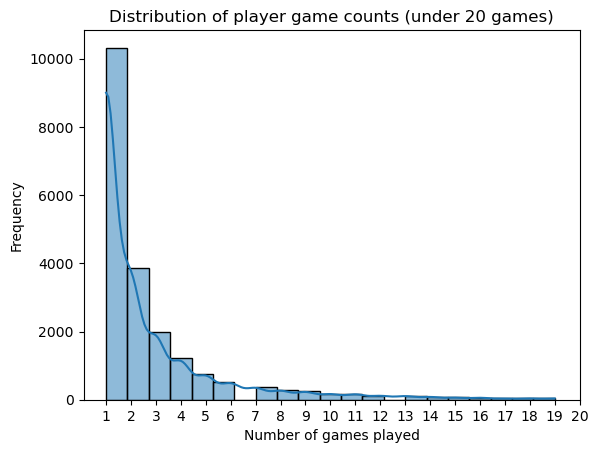

In [132]:
filtered_player_game_counts = player_game_counts[player_game_counts['games_count'] < 20]

plt.figure()

sns.histplot(data=filtered_player_game_counts, x='games_count', bins=21, kde=True)

plt.xlabel('Number of games played')
plt.ylabel('Frequency')
plt.title('Distribution of player game counts (under 20 games)')
plt.xticks(range(1, 21)) 

plt.show()

In [165]:
player_game_counts['win_ratio'] = player_game_counts['finished_paths_count'] / player_game_counts['games_count']
player_game_counts['win_ratio'].fillna(0, inplace=True)
players_with_at_least_two_games = player_game_counts[player_game_counts['games_count'] >= 2]
player_game_counts.describe()

,games_count,finished_paths_count,win_ratio
count,20866.000000,14244.000000,20866.000000
mean,3.651299,3.602499,0.569178
std,34.929576,41.644753,0.439719
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,2.000000,2.000000,0.666667
75%,3.000000,3.000000,1.000000
max,4865.000000,4865.000000,1.000000


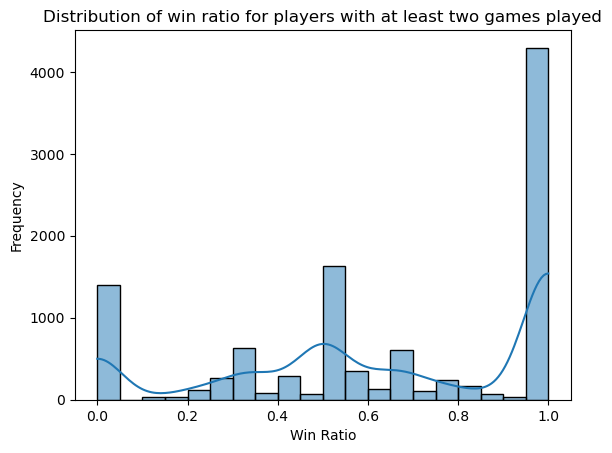

In [164]:
sns.histplot(data=players_with_at_least_two_games, x='win_ratio', bins=20, kde=True)

plt.xlabel('Win Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of win ratio for players with at least two games played')

plt.show()


# Hub Characterization Measures

In [145]:
# Create graph of wikispeedia with nodes being articles and edges being links
G_link = nx.from_pandas_edgelist(link_network, 'source', 'target', create_using=nx.DiGraph())

### Centrality Measures

#### Degree Centrality
Degree centrality measures the number of edges that connect to a node (i.e., the degree of the node). The more connections a node has, the more central it is.

For a graph \( G = (V, E) \) with \( n \) vertices, the degree centrality \( C_D(v) \) for a vertex \( v \) is defined as:
$$
C_D(v) = \frac{deg(v)}{n - 1}
$$
where \( deg(v) \) is the degree of \( v \), and \( n - 1 \) is the maximum possible degree of any vertex in a simple graph.

#### Betweenness Centrality
Betweenness centrality measures the extent to which a node lies on paths between other nodes. Nodes that frequently act as bridges between other nodes have higher betweenness centrality.

For a graph \( G = (V, E) \), the betweenness centrality \( C_B(v) \) for a vertex \( v \) is defined as:
$$
C_B(v) = \sum_{s \neq v \neq t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$
where \( \sigma_{st} \) is the total number of shortest paths from node \( s \) to node \( t \) and \( \sigma_{st}(v) \) is the number of those paths that pass through \( v \).

#### Closeness Centrality
Closeness centrality measures how close a node is to all other nodes in the graph (the sum of the shortest paths from this node to all other nodes). The idea is that nodes closer to others can spread information more efficiently.

For a connected graph \( G = (V, E) \), the closeness centrality \( C_C(v) \) for a vertex \( v \) is defined as:
$$
C_C(v) = \frac{n - 1}{\sum_{u \in V \setminus \{v\}} d(v, u)}
$$
where \( d(v, u) \) is the shortest-path distance between \( v \) and \( u \), and \( n - 1 \) is the number of nodes excluding \( v \) itself.

#### Eigenvector Centrality
Eigenvector centrality assigns relative scores to all nodes in the network based on the principle that connections to high-scoring nodes contribute more to the score of a node than equal connections to low-scoring nodes.

It is calculated by finding the eigenvector associated with the largest eigenvalue of the adjacency matrix \( A \) of the graph \( G \). If \( x \) is the eigenvector centrality of \( G \) and \( \lambda \) is the largest eigenvalue, then:
$$
Ax = \lambda x
$$
The centrality \( x_i \) of the node \( i \) is the \( i \)th element of the eigenvector \( x \).


In [146]:
# Calculating centrality measurement

# Function for Degree Centrality
def get_degree_centrality(G):
    return nx.degree_centrality(G)

# Function for Betweenness Centrality
def get_betweenness_centrality(G):
    return nx.betweenness_centrality(G)

# Function for Closeness Centrality
def get_closeness_centrality(G):
    return nx.closeness_centrality(G)

# Function for Eigenvector Centrality
def get_eigenvector_centrality(G):
    return nx.eigenvector_centrality(G)

In [147]:
# Calculate centralities for wikipedia links
degree_centrality_links = get_degree_centrality(G_link)
betweenness_centrality_links = get_betweenness_centrality(G_link)
closeness_centrality_links = get_closeness_centrality(G_link)
eigenvector_centrality_links = get_eigenvector_centrality(G_link)

# Create a DataFrame for players
centrality_df_links = pd.DataFrame({
    'Node': list(G_link.nodes()),
    'Degree Centrality': [degree_centrality_links[node] for node in G_link.nodes()],
    'Betweenness Centrality': [betweenness_centrality_links[node] for node in G_link.nodes()],
    'Closeness Centrality': [closeness_centrality_links[node] for node in G_link.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality_links[node] for node in G_link.nodes()]
})

print(centrality_df_links)

                                  Node  Degree Centrality  \
0                           linkSource           0.000218   
1                           linkTarget           0.000218   
2     %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                                 Bede           0.008491   
4                              Columba           0.005008   
...                                ...                ...   
4589                      Yellowhammer           0.002830   
4590                    Yotsuya_Kaidan           0.000435   
4591            You%27re_Still_the_One           0.000435   
4592                    Yungay%2C_Peru           0.000871   
4593                        Zara_Yaqob           0.001306   

      Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  
0                   0.000000              0.000000            4.240657e-24  
1                   0.000000              0.000218            5.512854e-23  
2                   0.000000        

### Clustering Coefficients for Directed Graphs

Clustering coefficients measure the likelihood that two neighbors of a node are also neighbors of each other, forming a triangle in the graph. For directed graphs, the concept is extended to account for the directionality of connections.

#### Directed Clustering Coefficients

For a directed graph \( G = (V, E) \), the clustering coefficient can be defined for each node based on the directed triangles they participate in. There are three types of directed triangles:

- **Outgoing Triangles**: Triangles that a node \( v \) points to, i.e., \( v \) has directed edges going out to the other two nodes.
- **Incoming Triangles**: Triangles that point to the node \( v \), i.e., the other two nodes have directed edges going into \( v \).
- **Cyclic Triangles**: Triangles where the edges form a cycle, i.e., each node points to another node in a cyclic manner.

The directed clustering coefficient for a node \( v \) is typically the average of the local clustering coefficients for each type of triangle:

$$
C_{dir}(v) = \frac{1}{3} (C_{out}(v) + C_{in}(v) + C_{cycle}(v))
$$

where \( C_{out}(v) \), \( C_{in}(v) \), and \( C_{cycle}(v) \) are the local clustering coefficients for outgoing, incoming, and cyclic triangles respectively.

The local clustering coefficient for each type of triangle is calculated as:

$$
C_{type}(v) = \frac{\text{Number of triangles of a given type including } v}{\text{Number of possible triangles of that type for } v}
$$

In [148]:
# Calculate clustering coefficients according to formula above
directed_clustering_coefficient = nx.clustering(G_link)

# Put the coefficients in a list for plotting
directed_clustering_values = list(directed_clustering_coefficient.values())


### Plot distribution of each centrality measure


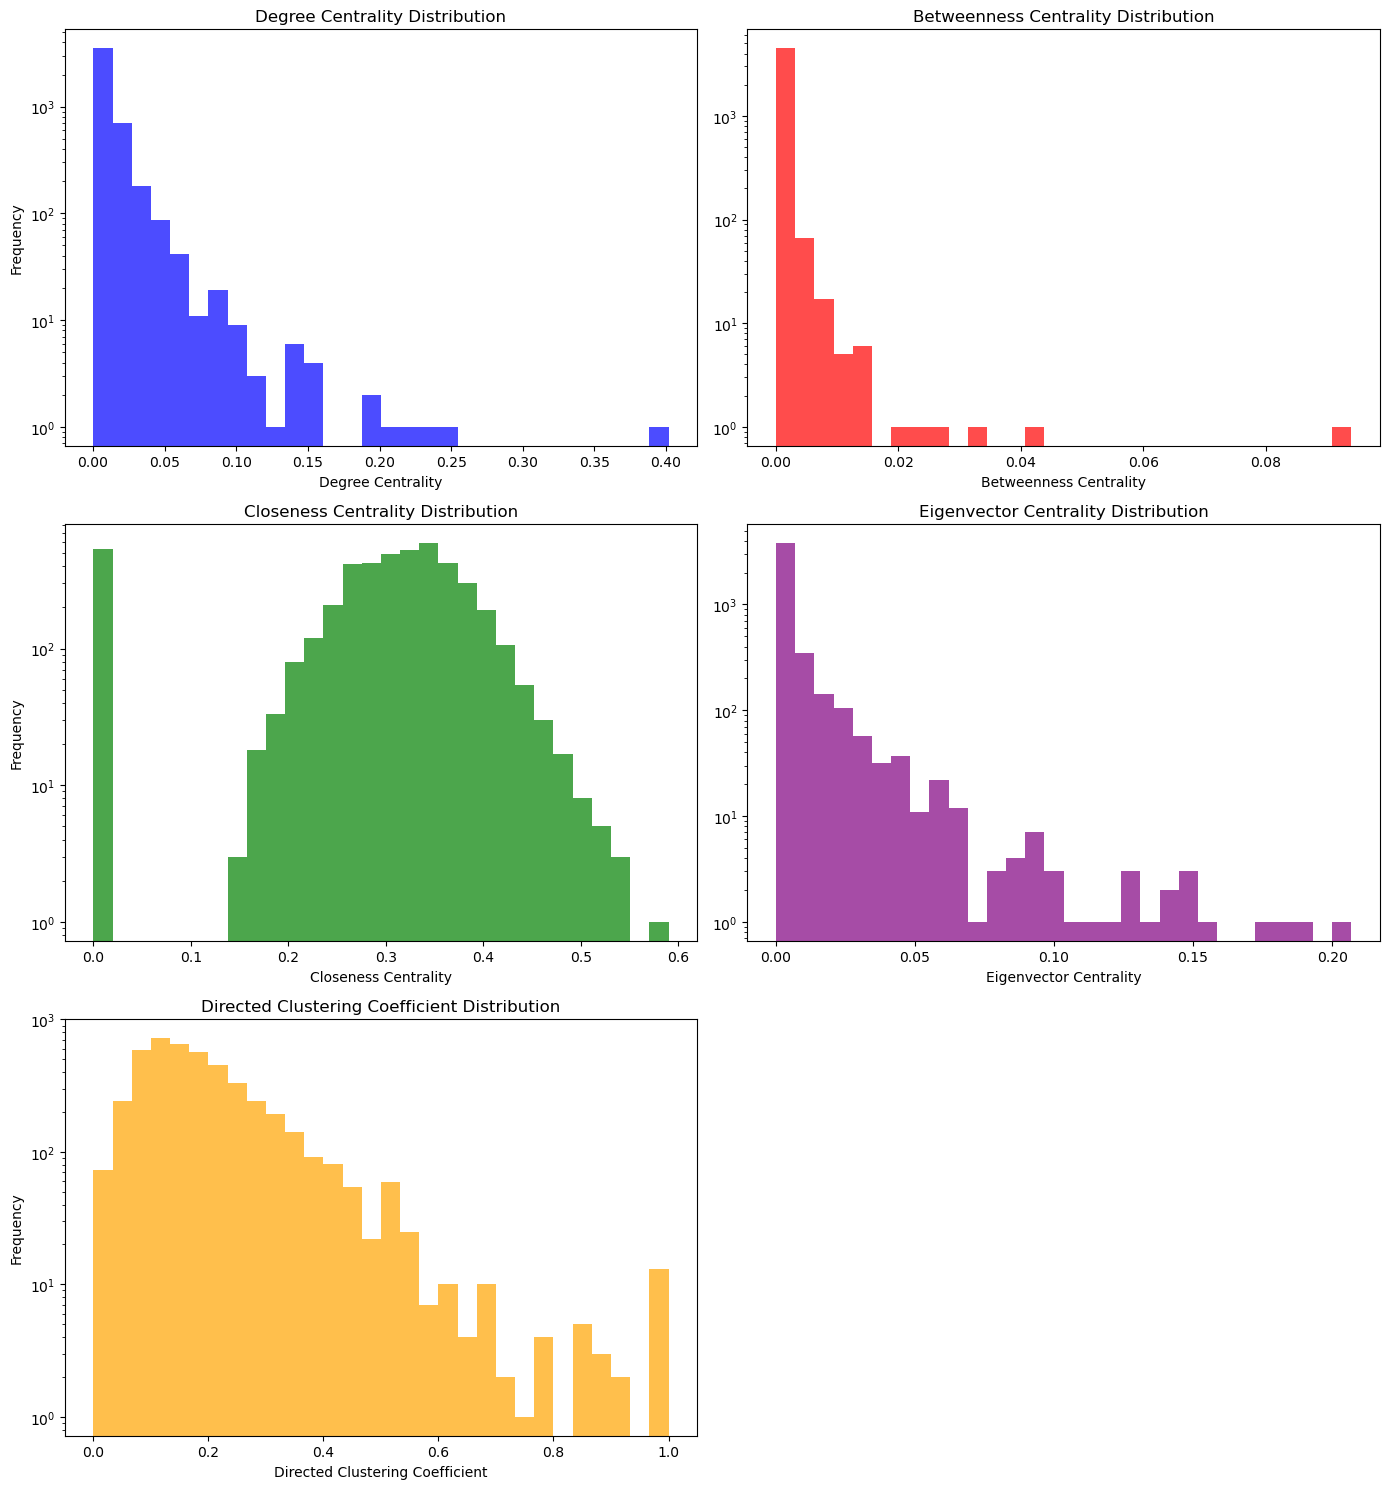

In [149]:
# Plot distribution of each centrality measure

# Set the size of the overall figure
plt.figure(figsize=(14, 15))

# Degree Centrality Distribution
plt.subplot(3, 2, 1)
plt.hist(centrality_df_links['Degree Centrality'], bins=30, color='blue', alpha=0.7,log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness Centrality Distribution
plt.subplot(3, 2, 2)
plt.hist(centrality_df_links['Betweenness Centrality'], bins=30, color='red', alpha=0.7,log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness Centrality Distribution
plt.subplot(3, 2, 3)
plt.hist(centrality_df_links['Closeness Centrality'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector Centrality Distribution
plt.subplot(3, 2, 4)
plt.hist(centrality_df_links['Eigenvector Centrality'], bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Directed Clustering Coefficient Distribution
plt.subplot(3, 2, 5)  # Adjust to a 3x2 subplot grid
plt.hist(directed_clustering_values, bins=30, color='orange', alpha=0.7, log=True)
plt.title('Directed Clustering Coefficient Distribution')
plt.xlabel('Directed Clustering Coefficient')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [150]:
import sys
!{sys.executable} -m pip install mpld3


In [151]:
#!pip install mpld3
"""

import matplotlib.pyplot as plt
import mpld3

# Create a 2x3 grid for 5 plots (one will be empty)
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

# Degree Centrality Distribution
axs[0, 0].hist(centrality_df_links['Degree Centrality'], bins=30, color='blue', alpha=0.7, log=True)
axs[0, 0].set_title('Degree Centrality Distribution')
axs[0, 0].set_xlabel('Degree Centrality')
axs[0, 0].set_ylabel('Frequency')

# Betweenness Centrality Distribution
axs[0, 1].hist(centrality_df_links['Betweenness Centrality'], bins=30, color='red', alpha=0.7, log=True)
axs[0, 1].set_title('Betweenness Centrality Distribution')
axs[0, 1].set_xlabel('Betweenness Centrality')

# Closeness Centrality Distribution
axs[0, 2].hist(centrality_df_links['Closeness Centrality'], bins=30, color='green', alpha=0.7, log=True)
axs[0, 2].set_title('Closeness Centrality Distribution')
axs[0, 2].set_xlabel('Closeness Centrality')
axs[0, 2].set_ylabel('Frequency')

# Eigenvector Centrality Distribution
axs[1, 0].hist(centrality_df_links['Eigenvector Centrality'], bins=30, color='purple', alpha=0.7, log=True)
axs[1, 0].set_title('Eigenvector Centrality Distribution')
axs[1, 0].set_xlabel('Eigenvector Centrality')

# Directed Clustering Coefficient Distribution
axs[1, 1].hist(directed_clustering_values, bins=30, color='orange', alpha=0.7, log=True)
axs[1, 1].set_title('Directed Clustering Coefficient Distribution')
axs[1, 1].set_xlabel('Directed Clustering Coefficient')
axs[1, 1].set_ylabel('Frequency')

# Hide the last subplot (bottom right) since there is no data for it
axs[1, 2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure to HTML
mpld3.save_html(fig, "interactive_plots.html")

# If you need to display the plot in Jupyter Notebook as well, uncomment the next line
mpld3.display()
"""

'\n\nimport matplotlib.pyplot as plt\nimport mpld3\n\n# Create a 2x3 grid for 5 plots (one will be empty)\nfig, axs = plt.subplots(2, 3, figsize=(14, 10))\n\n# Degree Centrality Distribution\naxs[0, 0].hist(centrality_df_links[\'Degree Centrality\'], bins=30, color=\'blue\', alpha=0.7, log=True)\naxs[0, 0].set_title(\'Degree Centrality Distribution\')\naxs[0, 0].set_xlabel(\'Degree Centrality\')\naxs[0, 0].set_ylabel(\'Frequency\')\n\n# Betweenness Centrality Distribution\naxs[0, 1].hist(centrality_df_links[\'Betweenness Centrality\'], bins=30, color=\'red\', alpha=0.7, log=True)\naxs[0, 1].set_title(\'Betweenness Centrality Distribution\')\naxs[0, 1].set_xlabel(\'Betweenness Centrality\')\n\n# Closeness Centrality Distribution\naxs[0, 2].hist(centrality_df_links[\'Closeness Centrality\'], bins=30, color=\'green\', alpha=0.7, log=True)\naxs[0, 2].set_title(\'Closeness Centrality Distribution\')\naxs[0, 2].set_xlabel(\'Closeness Centrality\')\naxs[0, 2].set_ylabel(\'Frequency\')\n\n# Ei

In [153]:
centrality_df_links['Degree Centrality']

0       0.000218
1       0.000218
2       0.002395
3       0.008491
4       0.005008
          ...   
4589    0.002830
4590    0.000435
4591    0.000435
4592    0.000871
4593    0.001306
Name: Degree Centrality, Length: 4594, dtype: float64

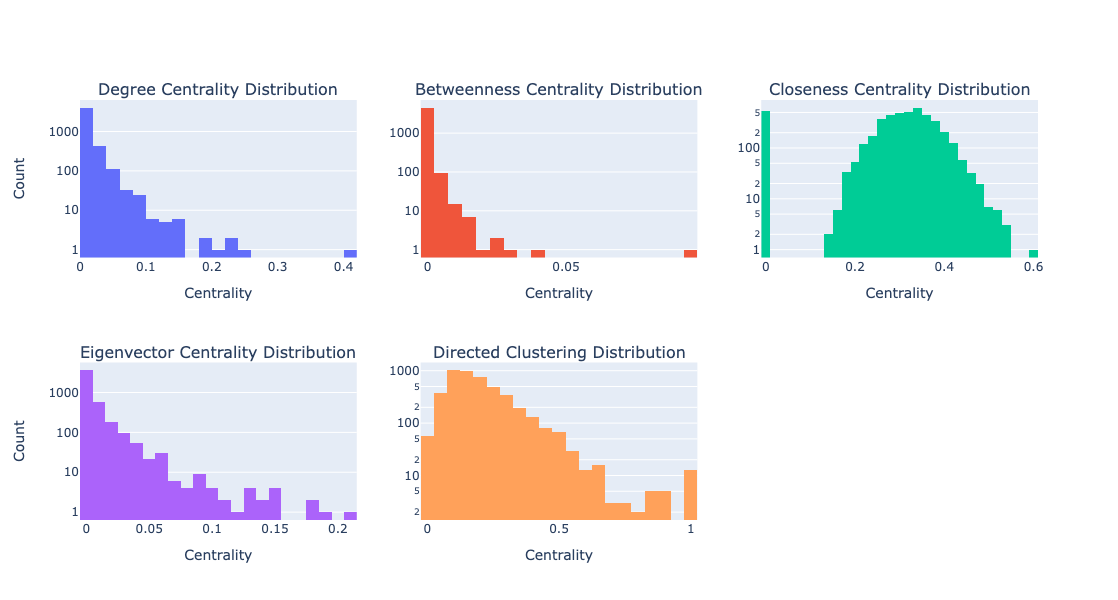

'interactive_plots.html'

In [235]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 2 rows and 3 columns
fig = make_subplots(rows=2, cols=3, subplot_titles=(
    'Degree Centrality Distribution', 
    'Betweenness Centrality Distribution', 
    'Closeness Centrality Distribution',
    'Eigenvector Centrality Distribution',
    'Directed Clustering Distribution'
))


# Define your data here
centrality_df_links = centrality_df_links # Your data for centrality
directed_clustering_values = directed_clustering_values # Your data for clustering coefficient


# Add histograms to the subplots
fig.add_trace(go.Histogram(x=centrality_df_links['Degree Centrality'], nbinsx=30), row=1, col=1)
fig.add_trace(go.Histogram(x=centrality_df_links['Betweenness Centrality'], nbinsx=30), row=1, col=2)
fig.add_trace(go.Histogram(x=centrality_df_links['Closeness Centrality'], nbinsx=30), row=1, col=3)
fig.add_trace(go.Histogram(x=centrality_df_links['Eigenvector Centrality'], nbinsx=30), row=2, col=1)
fig.add_trace(go.Histogram(x=directed_clustering_values, nbinsx=30), row=2, col=2)

# Hide the empty subplot
fig.update_layout(showlegend=False)

# Set the axis to log type where needed
# Note that for log scale on the x-axis in histograms, you'll need to use histnorm='log' in the go.Histogram
# The below example shows how to set the y-axis to log type
fig.update_yaxes(type='log', row=1, col=1)
fig.update_yaxes(type='log', row=1, col=2)
fig.update_yaxes(type='log', row=1, col=3)
fig.update_yaxes(type='log', row=2, col=1)
fig.update_yaxes(type='log', row=2, col=2)

# Update layout to add titles and labels
# Here's an example for the first subplot
fig.update_xaxes(title_text='Centrality')
fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_yaxes(title_text='Count', row=2, col=1)


# Repeat the above two lines to set titles and labels for all other subplots

# Adjust layout to prevent overlap and set the size of the overall figure
fig.update_layout(height=600, width=1000)

# Show the figure
fig.show()

import plotly.offline
plotly.offline.plot(fig, filename='interactive_plots.html')
